In [ ]:
import os
try:
    print("JAVA_HOME is set to",os.environ["JAVA_HOME"])
except KeyError as err:
    os.environ["JAVA_HOME"] = "/Library/Java/JavaVirtualMachines/jdk1.8.0_221.jdk/Contents/Home"
    print("Had to set JAVA_HOME is set to",os.environ["JAVA_HOME"],"\n   --- what is going on here...")

# Streaming Analysis of Video Frames


This is the image processing portion of the [wikiImageAnalysis](wikiImageAnalysis.jupyter-py36.ipynb), deploying only the image collection/analysis portion. The wikiImageAnalysis project walks through the processes of 
deriving images from the wiki feed, a multistep process. In the instances that you have a supply of images, 
,video stream or mpeg files, their is no derivation process. 

The notebook composes and submits three applications that
- Receive image/video frames via Kafka.
- Uses a Face Detection model locate faces in the frames. 
- Uses a Object Detection mode to locates objects (person, car, bicycle, boat...)

A rendering accompanies each of the models. 

The [videoToAnalysis](videoToAnalysis.jupyter-py36.ipynb) notebook publishes video frames to the Kafka to complete the example. 



## <a id="Overview  - Continious processing with Streams">OVERVIEW</a>
The image below show the entire application, encoded images flow into the VideoFrame operator from Kafka, the frame is decode in 'kafka_frame' and published to the other Streams via 'pubImageA..'

![graph of application](images/imageOnlyApplications.png)



### Documentation

- [Streams Python development guide](https://ibmstreams.github.io/streamsx.documentation/docs/latest/python/)
- [Streams Python API](https://streamsxtopology.readthedocs.io/)
- [Topology](https://streamsxtopology.readthedocs.io/en/latest/index.html) Streams Topology documentation
- [Widgets](https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20Basics.html) Notebook Widgets documentation.



# <a id='SETUP'>Setup</a>

## <a id='setupImports'>Setup Imports</a>

In [ ]:
# Install components
#!pip --user install SSEClient===0.0.22 --upgrade
#!pip install --user --upgrade streamsx

Additional installs. 
- pip install streamsx.eventstreams

Initial imports are in support of accessing Streams with Wikipedia data, 
subsequent are in support of rendering the results as they flow back from 
Streams. 

In [5]:
import json
import datetime 
import os
import sys
import time
import threading


from  functools import lru_cache
from statistics import mean
import collections
from collections import deque
from collections import Counter

import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import Button, HBox, VBox, Layout
from IPython.core.debugger import set_trace
from IPython.display import display, clear_output

#from bs4 import BeautifulSoup
#from sseclient import SSEClient as EventSource
import requests

import streamsx
from streamsx.topology.topology import *
import streamsx.rest as rest
from streamsx.topology import context
if '../scripts' not in sys.path:
    sys.path.insert(0, '../scripts')
    
#import ipynb

import streams_aid as aid
import streams_render as render
import credential
import cvsupport
print("streamsx package version: " + streamsx.topology.context.__version__)



streamsx package version: 1.14.15


In [3]:
import cv2
cv2.__version__

'4.2.0'

## Helper functions used in interfacing  to Streams  

Their are number of helper functions to make it aid in the development of Streams applicatons, refer to scripts/streams_aid.py or utilize.

For details on the avaliable aid functions, use the help command.


## <a id='setupCredentials'>Setup Credentials</a>

The service that you use defines what you need to setup.

- Describe CP4D
- Describe Cloud 
### Add credentials for the IBM Streams service

#### ICP4D setup

With the cell below selected, click the "Connect to instance" button in the toolbar to insert the credentials for the service.

<a target="blank" href="https://developer.ibm.com/streamsdev/wp-content/uploads/sites/15/2019/02/connect_icp4d.gif">See an example</a>.

#### Cloud setup
To use Streams instance running in the cloud setup a [credential.py](setup_credential.ipynb)



In [6]:
# If your using the cloud set the name of the Cloud Streams instance you will be using. 
# Credential data 
SERVICE_NAME='Streaming3Turbine'

In [8]:
instance,cfg = aid.get_instance(service_name=SERVICE_NAME)

Outside ICP4D


### Connect to the server :  ICP4D or Cloud instance -


In [7]:
# The code is setup to run in the Cloud and CP4D. 
# If in the Cloud, you'll see a message.
# If in CP4D, you'll need the service credential, which what the above link explains. 
#    Delete this cell and use the above instructions if you only using CP4D.

try:
    from icpd_core import icpd_util
except ModuleNotFoundError as e:  # get all exceptions
    instance,cfg = aid.get_instance(service_name=SERVICE_NAME)

else:   # runs when no exception occurs
    cfg=icpd_util.get_service_instance_details(name='zen-sample-icp1-blitz-env')

Outside ICP4D


## Connected
When you're up to this point you have established connection to the Streams instance. The cell below shows, if any, the applications that are running. For the applications that are running thier corresponding rendering codes could be executed without going through the process of submitting the application.

In [ ]:
aid.list_jobs(instance, cancel=True)

Next compose and submit the first appication or back to the [Directory](#DIRECTORY) 

Thier may not be any jobs currently running. 

Continue on to compose an application or [back to Directory](#DIRECTORY) 

<tr style="border-bottom: 1px solid #000;">

## View into the live stream
The [view](https://streamsxtopology.readthedocs.io/en/latest/streamsx.topology.topology.html#streamsx.topology.topology.Stream.view) enables access to live stream at runtime. We spread them liberaly throughout the application to observe how the processing is procedeing

### Viewing live data:
- constructing the view object : https://streamsxtopology.readthedocs.io/en/latest/streamsx.topology.topology.html?highlight=view#streamsx.topology.topology.Stream.view
- methods on the view object : https://streamsxtopology.readthedocs.io/en/latest/streamsx.topology.topology.html?highlight=view#streamsx.topology.topology.View

In [ ]:
# Notebook support

def render_image(image_url=None, output_region=None):
    """Write the image into a output region.
    
    Args::
        url: image
        output_region: output region
        
    .. note:: The creation of the output 'stage', if this is not done the image is rendered in the page and
        the output region. 
        
    """
    
    try:
        response = requests.get(image_url)
        stage = widgets.Output(layout={'border': '1px solid green'})
    except:
        print("Error on request : ", image_url)
    else:
        if response.status_code == 200:
            with output_region:
                stage.append_display_data(widgets.Image(
                    value=response.content,
                    #format='jpg',
                    width=300,
                    height=400,
                ))
            output_region.clear_output(wait=True) 

ana_stage = list()
def display_image(tup, image_region=None, title_region=None, url_region=None):
    if tup['img_desc'] is not None and len(tup['img_desc']) > 0:
        display_desc = tup['img_desc'][0]
        ana_stage.append(display_desc)
        title_region.value = "Img Title:{}".format(display_desc['title'] )
        url_region.value = "{}".format(display_desc['img'])
        render_image(image_url=display_desc['img'], output_region=image_region)

# <a id='PHASE5'>Recieve Video Frames via Kafka - VideoRcvKafka</a>
- subscribe to kafka 'image_active' 
- publish to 'image_active' topic

In [ ]:
import streamsx.eventstreams as eventstreams
from streamsx.topology.schema import CommonSchema

def VideoRcvKafka():
    """Recieve video frame on topic and publish to 'image_string'. 
    
    Notes:
        - The script VideoSndKafka.py pushed video frame onto the topic.
    
    
    """
    topo = Topology("VideoRcvKafka")
    topo.add_pip_package('opencv-contrib-python')

    video_chunk = eventstreams.subscribe(topo, schema=CommonSchema.Json, 
                                         credentials=json.loads(credential.magsEventStream),
                                         topic='VideoFrame' )
    kafka_frame = video_chunk.map(cvsupport.BuildVideoFrame(), name="kafka_frame")
    kafka_frame.view(name="frame_kafka", description="frame from kafka image")
    kafka_frame.publish(topic="image_active", name="pubImageActive")
    return topo


aid.cloudSubmit(instance, SERVICE_NAME, VideoRcvKafka(), credential) 


[Directory](#DIRECTORY) 

## <a id='PHASE4.1'>Compose and submit 'FaceAnalysis' application</a>
- subscribe to 'image_active' topic
- Find faces in images
- Less sophisticated Model
![graph of application](images/faceAnalysis.png)

In [ ]:
## compose the findImageElements application
import cvsupport

def FaceAnalysis():
    """Analyse the images with various tools. 
       - Subscribe to 'image_active' with encoded images in 'image_string'
       - process 'image_string' with FaceRegions into 'face_regions' 
       
    """
    topo = Topology("FaceAnalysis")
    topo.add_file_dependency('../datasets/haarcascade_frontalface_default.xml', 'etc')
    topo.add_pip_package('opencv-contrib-python')   
    
    image_active = topo.subscribe(topic="image_active", name="subImageActive")
    
    # Find faces analysis ....
    face_regions = image_active.map(cvsupport.FaceRegions(), name="face_regions")
    face_trimmed = face_regions.map(lambda t: {
        'url':t['img_desc'][0]['img'], 
        'face_regions':t['face_regions'],
        'image_string':t['image_string']
    }, name="faces_trimmed")
    face_trimmed.view(name="faces_view", description="faces regions")
    return topo

aid.cloudSubmit(instance, SERVICE_NAME, FaceAnalysis(), credential)


 [Directory](#DIRECTORY) 
## <a id='PHASE4.2'>Compose and submit 'ObjectAnalysis' application</a>
- subscribe to 'image_active' topic
- Analysis operator that does analysis: findObject.
- More sophisticated model
- Bigger longer to submit
![graph of application](images/objectAnalysis.png)




In [ ]:
def ObjectAnalysis():
    """Analyse the images with various tools. 
       - Subscribe to 'image_active' with encoded images in 'image_string'
       - process 'image_string' with ObjectRegions into 'object_regions'
       - 
       
    """
    topo = Topology("ObjectAnalysis")
    topo.add_file_dependency('../datasets/haarcascade_frontalface_default.xml', 'etc')
    topo.add_file_dependency('../datasets/yolov3.weights', 'etc')
    topo.add_file_dependency('../datasets/yolov3.cfg', 'etc')
    topo.add_pip_package('opencv-contrib-python')    
    image_active = topo.subscribe(topic="image_active", name="subImageActive")
    
    # Find objects analysis ...
    object_regions = image_active.map(cvsupport.ObjectRegions(classes="../datasets/yolov3.txt"), name="object_fetch")
    object_trimmed = object_regions.map(lambda t: {
        'url':t['img_desc'][0]['img'], 
        'object_regions':t['object_regions'],
        'image_string':t['image_string']
    }, name="objects_trimmed")
    object_trimmed.view(name="objects_view", description="object regions")
    return topo


## Compose and submit the findElements Application 


aid.cloudSubmit(instance, SERVICE_NAME, ObjectAnalysis(), credential) 

[Back to Directory](#DIRECTORY)
## <a id='PHASE5.1'>View the ImageAnalysis application's FacesRegions results - </a>

In [ ]:
# SHOW Found Faces
face_dash = render.faceDashboard(instance, sleep=2)
display(face_dash.dashboard)
face_dash.ignition(True)

[Back to Directory](#DIRECTORY)
## <a id='PHASE5.2'>View the ImageAnalysis application's ObjectRegions results</a>
Display the images and the objects they found. Run in a thread to make is easier to stop.

On the Streams side it's processing the images to find objects, if not no objects are 
found they are not pushed to the view and will not be rendered here.

The object detection maybe CPU intensive (you don't say) you may want to distribute this across hardware, which
is left as an exercise to the user.



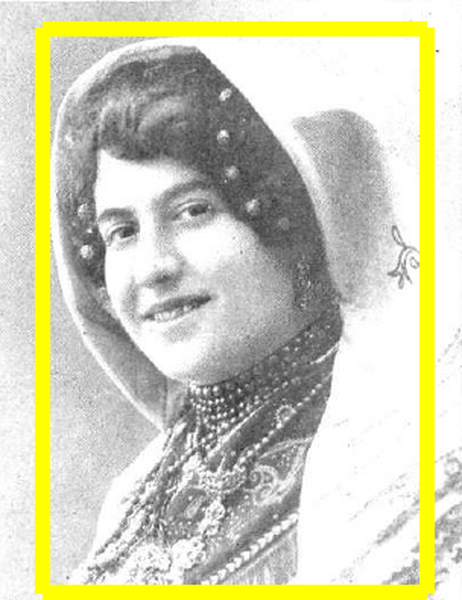

In [9]:
object_dash = render.objectDashboard(instance, sleep=.2)
display(object_dash.dashboard)
object_dash.ignition(True)

[Back to Directory](#DIRECTORY)